# Flair Classification using BERT
Earlier I tried using ```BERT``` model pre-trained on lower case english letters. Although the results were good, but for production level with memory constraint that model was not a good choice, as the model was too big.

So instead using BERT, I am using ```DistilBert```, which is a smaller version of BERT, having only 6 layers and 66M parameters, in comparison to ```BERT``` which has 12 layers and 110M parameters. This model also gives similar results and is also fast and cheap in terms of resuorce consumption

## Data PreProcessing
For classification simply putting the whole raw data into the model is not enough.<br>
To get Good results we have to first decide what data is to be considered for training and then preprocess the data.

In [1]:
!pip install emoji

     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=238204d156cddf37e22419a429cb8ca390453ff76447eea6852d4c3eac768ce5
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [2]:
# import required libraries, modules for data preprocessing
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
# loading train and valid data
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('valid.csv')

In [4]:
train_df.head()

,PostUploadTime,Headline,Flair,Rating,UserName,UserPostKarma,UserCommentKarma,Id,PostSource,NumComments,Comments,PostBody
0,1.587106e+09,Man Arrested For Allegedly Spitting On Manipur...,Non-Political,111,ReallyRedditLover,1008.0,116.0,g2ph3l,https://www.ndtv.com/mumbai-news/man-arrested-...,7,">The accused was identified as **Amir Khan** ,...",NaN
1,1.587106e+09,Bought air tickets during lockdown? Full refun...,Coronavirus,8,ReallyRedditLover,1008.0,116.0,g2pg1d,https://timesofindia.indiatimes.com/business/i...,2,"So, If I booked the ticket on 21st for 26th Ma...",NaN
2,1.587105e+09,Bollywood Nazis: A Tale of Two Sisters,Politics,19,iSalaamU,32174.0,14938.0,g2pd5o,https://www.reddit.com/r/india/comments/g2pd5o...,7,Woah so permanent ban right ? Not temporary .....,"Yesterday, Twitter permanently suspended the a..."
3,1.587105e+09,"On this occasion of Rongāli bihu, I'd love to ...",Non-Political,10,deboo117,8370.0,2700.0,g2p97t,https://open.spotify.com/playlist/21uBCM64wmKV...,0,NaN,NaN
4,1.587104e+09,A Tweet Asking For Muslims And Journalists To ...,Coronavirus,1,NaN,NaN,NaN,g2ovv5,https://www.buzzfeednews.com/article/pranavdix...,1,NaN,[deleted]


In [5]:
valid_df.head()

,PostUploadTime,Headline,Flair,Rating,UserName,UserPostKarma,UserCommentKarma,Id,PostSource,NumComments,Comments,PostBody
0,1.587444e+09,I want to be calm like that guy sitting on the...,Photography,4,OtsuKotsu,1209.0,2681.0,g50xtt,https://i.redd.it/kjkywsmcc1u41.jpg,0,NaN,NaN
1,1.587444e+09,Coronavirus Proof Greetings,Coronavirus,1,Brilliant_Bharat,1.0,0.0,g50xbz,https://www.brilliantbharat.com/2020/04/19/cor...,0,NaN,NaN
2,1.587444e+09,1.7 million dollar cost project in Pakistan.,Business/Finance,1,Deejhons786,1330.0,22.0,g50uin,https://youtu.be/GsUWJ9MTHWc,0,NaN,NaN
3,1.587444e+09,Refer and Earn- Rs. 5 per refer - No minimum w...,Business/Finance,1,HashOneandOnly,1.0,0.0,g50q4h,https://www.reddit.com/r/india/comments/g50q4h...,0,NaN,[removed]
4,1.587444e+09,Amazon reviews gold ! A 'massager' that clearl...,Non-Political,6,zakiiboy,15811.0,2902.0,g50nld,https://i.redd.it/5tuf59qq91u41.jpg,1,"Yes, the product description is not a giveaway...",NaN


#### textPreProcess
For training the Text classifier, as feature I will concat all the text present in the ```Headline```, ```PostBody``` and ```Comments``` as a single ```text``` body. And then apply text preprocessing.}

In [0]:
def textPreProcess(text, rem_stop=False):
  """
  Function to process text data and remove non neccessary information
  1. converting emojis to text
  2. lower casing
  3. removing punctuations, urls
  4. removing stop words
  5. lemmatization 
  Args:
    text (str): text data
    rem_stop (bool): whether to remove stopping words or not
  Return:
    text (str): processed text data
  """
  # converting emojis to text
  text = emoji.demojize(text)
  # removing empty space at start and end of text and lower casing
  text = text.strip().lower()
  # removing punctuation
  PUNCTUATIONS = '[!()\-[\]{};:"\,<>/?@#$%^&.*_~]'
  text = re.sub(PUNCTUATIONS, "", text)
  # removing url links
  urlPattern = re.compile(r'https?://\S+|www\.\S+')
  urlPattern.sub('', text)

  # updating stopping words list
  if rem_stop:
    stopWords = list(stopwords.words('english'))
  else:
    stopWords = []

  # lemmatizing, removing stop word, removing emojis
  lemmaWords=[]
  Lemma=WordNetLemmatizer()
  for word in text.split():
    # removing stop words
    if word not in stopWords:
      lemmaWords.append(Lemma.lemmatize(word.strip()))
  text = " ".join(lemmaWords)

  return text

In [7]:
train_df['Flair'].unique()

array(['Non-Political', 'Coronavirus', 'Politics', 'Policy/Economy',
       'Food', 'Science/Technology', 'Business/Finance', 'Photography',
       'Sports'], dtype=object)

***Function to process text data and remove unneccessary information***<br>
 The flow of text while preprocessing->
  1. converting emojis to text
  2. lower casing
  3. removing punctuations, urls
  4. removing stop words
  5. lemmatization
  
Although stemming is fast but lemmatization retains word meaning and gives better results

In [0]:
category = {'Non-Political':0, 'Coronavirus':1, 'Politics':2,
            'Policy/Economy':3, 'Food':4, 'Science/Technology':5,
            'Business/Finance':6, 'Photography':7, 'Sports':8}
            
def getClasData(df):
  data = pd.DataFrame(columns=['Text', 'Flair'])
  data['Text'] = df['Headline'].map(str) + df['PostBody'].map(str) + df['Comments'].map(str)
  data['Flair'] = df['Flair'].map(str)

  data['Text'] = data['Text'].apply(lambda text: textPreProcess(text))
  # data['Flair'] = le.transform(data['Flair'])
  data['Flair'] = data['Flair'].apply(lambda flair: category[flair])
  return data

In [0]:
clean_train = getClasData(train_df)
clean_valid = getClasData(valid_df)

In [0]:
# saving cleaned data into csv files
clean_train.to_csv('clean_train_data.csv')
clean_valid.to_csv('clean_valid_data.csv')

In [11]:
!pip install transformers

     |████████████████████████████████| 573kB 13.5MB/s 
     |████████████████████████████████| 890kB 13.6MB/s 
     |████████████████████████████████| 1.0MB 47.7MB/s 
     |████████████████████████████████| 3.7MB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=99fe25d60d1a55e6dafbd99b0529dc8257fc59087956e0777c3c978d6e76540a
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


## Creating Dataloaders and Model definition

In [0]:
# import required libraries for training, inference and model selection
import transformers
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import AdamW, AdamWeightDecay
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random

In [0]:
class RedditData(Dataset):
  def __init__(self, path, maxlen):
    # read csv data file
    self.df = pd.read_csv(path)
    # maximum length of the text to be considered
    self.maxlen = maxlen
    # tokenizer
    self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

  def __len__(self):
    # returns the lenght of dataFrame
    return len(self.df)

  def __getitem__(self, idx):
    """Returns the text tokens and labels based on the index(idx)"""
    # text data
    text = self.df['Text'].iloc[idx]
    # label(flair) of the text
    label = self.df['Flair'].iloc[idx]

    # get token ids and attention mask
    tokens_dict = self.tokenizer.encode_plus(text =text,
                          add_special_tokens=True,
                          max_length = self.maxlen,
                          pad_to_max_length=True,
                          return_attention_mask=True)

    token_ids, labels = torch.tensor(tokens_dict['input_ids']), torch.tensor(label)
    attn_masks = torch.tensor(tokens_dict['attention_mask'])

    return token_ids, label, attn_masks

In [0]:
# Model Definition
# using pretrained model, and in our case the number of flair categories are 9
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)

In [2]:
# loading model onto the gpu
model.cuda()

NameError: name 'model' is not defined

In [ ]:
# creating testset and training set
train_set = RedditData('/content/clean_train_data.csv', 100)
test_set = RedditData('/content/clean_valid_data.csv', 150)
trainloader = DataLoader(train_set, shuffle = True, batch_size=8)
testloader = DataLoader(test_set, shuffle = True, batch_size=32)

In [0]:
# defining learning rate(lr), and optimizer
from torch import optim
lr = 2e-5
optimizer = AdamW(model.parameters(), lr = lr)

# schedular = optim.lr_scheduler.OneCycleLR(optimizer,
#                                     steps_per_epoch = len(trainloader),
#                                     epochs = 5, 
#                                     anneal_strategy = 'cos',
#                                     max_lr = 0.05,
#                                     cycle_momentum= True,
#                                     base_momentum = 0.7,
#                                     max_momentum = 0.8)

# check if cuda enabled gpu is available or not
# and set the device to available device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [0]:
def getAccuracy(preds, labels):
  """
  Function to calculate the Accuracy of the model
  Args:
      preds:  output of the model(predicted categories)
      labels: target values
  """
  # number of predictions
  n = preds.shape[0]
  # detaching from cuda
  preds = preds.detach().to('cpu')
  labels = labels.detach().to('cpu')
  # matching the dimensions of both prediction tensor and label tensor
  preds = preds.argmax(dim=-1).view(n, -1)
  labels = labels.view(n, -1)
  return ((preds==labels).sum()).float()/n

In [0]:
def seed_all(seed_value):
    """Function to reset the cpu and gpu variables
        this helps to regenerate same results
    """
    random.seed(seed_value) # Python
    torch.manual_seed(seed_value) # cpu vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value) # gpu variables

In [0]:
import time
def getTime(clk):
  '''
  function to convert seconds time into proper format
  Args:
    clk: time in seconds
  '''
  print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(clk)))

### Fine Tuning pretrained model
The model that I am using is pretrained on small cased english sentences from the data on the internet. But inorder to get best result for my data i will fine tune the model on my data

Here is the complete code for the training and evaluating model

In [51]:
EPOCHS = 10
seed = 27

# to regenerate the same results
seed_all(seed)
curr_time = 0
loss_list =[]
acc_list = []

train_time = 0

# complete training+validation time
for epoch in range(EPOCHS):
    print("-------- Epoch: {} --------".format(epoch+1))

    ##########################
    #       Training       #
    ##########################
    
    # training time in one epoch
    curr_time = time.time()
    model.train()
    batch_loss=0
    pbar = tqdm(enumerate(trainloader), leave = False, total = len(trainloader))
    for idx, (tokens, labels, masks) in pbar:
        tokens = tokens.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        model.zero_grad()
        
        output = model(tokens,
                    labels = labels,
                    attention_mask= masks)
        loss = output[0]
        loss_list.append(loss)
        batch_loss+=loss.item()

        loss.backward()
        optimizer.step()
        # schedular.step()

    ##########################
    #       Validation       #
    ##########################
    model.eval()
    avg_acc=0
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), leave = False, total = len(testloader))
        for idx, (tokens, labels, masks) in pbar:
            tokens = tokens.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            output = model(tokens,
                          attention_mask = masks)
            # output=> probabilities
            valid_acc = getAccuracy(output[0], labels)
            avg_acc+=valid_acc
            acc_list.append(valid_acc)

    train_time = time.time() - curr_time

    print('Epoch: {}/{} | Training loss: {:.4f} | Accuracy: {:.4f}'.format(epoch+1, EPOCHS, batch_loss/len(trainloader), avg_acc.item()/len(testloader)))
    getTime(train_time)
    print("")

-------- Epoch: 1 --------


Epoch: 1/10 | Training loss: 1.2907 | Accuracy: 0.6188
Time Taken: 00:03:32

-------- Epoch: 2 --------


Epoch: 2/10 | Training loss: 0.9152 | Accuracy: 0.6275
Time Taken: 00:03:32

-------- Epoch: 3 --------


Epoch: 3/10 | Training loss: 0.6460 | Accuracy: 0.6225
Time Taken: 00:03:32

-------- Epoch: 4 --------


Epoch: 4/10 | Training loss: 0.4148 | Accuracy: 0.6275
Time Taken: 00:03:33

-------- Epoch: 5 --------


Epoch: 5/10 | Training loss: 0.2576 | Accuracy: 0.6312
Time Taken: 00:03:33

-------- Epoch: 6 --------


Epoch: 6/10 | Training loss: 0.1745 | Accuracy: 0.6138
Time Taken: 00:03:32

-------- Epoch: 7 --------


Epoch: 7/10 | Training loss: 0.1335 | Accuracy: 0.6362
Time Taken: 00:03:32

-------- Epoch: 8 --------


Epoch: 8/10 | Training loss: 0.1038 | Accuracy: 0.6388
Time Taken: 00:03:32

-------- Epoch: 9 --------


Epoch: 9/10 | Training loss: 0.0887 | Accuracy: 0.6388
Time Taken: 00:03:32

-------- Epoch: 10 --------


Epoch: 10/10 | Training loss: 0.0808 | Accuracy: 0.6462
Time Taken: 00:03:32



In [0]:
def saveModel(model, filepath, category):
    """
    Args:
        model: training model
        filepath: (optional) model parameters are saved at "filepath"
    """
    filepath = filepath+'_model.pth'
        
    torch.save({
            'model' : model,
            'state_dict': model.state_dict(),
            'category': category,
            # 'optimizer':optimizer.state_dict(),
            }, filepath)
    print("Model saved at {}".format(filepath))

def loadModel(filepath):
    """
    -Function to load saved model and saved states
    -Args:
        filpath (str): path to the saved model
    """
    # load saved model dictionary
    saved = torch.load(filepath, map_location = 'cpu')
    state_dict = saved['state_dict']
    cat_dict = saved['category']
    return cat_dict, state_dict

In [0]:
# save current model
saveModel(model, '/content/distilbert', category)

Model saved at /content/distilbert_model.pth


### freezing complete model but classification layers for further Fine Tuning

Training only the classifier(linear) layers sometimes leads to good results, as the other layers are also dependent on the word selection during training so we have to first fine tune the earlier layers for our data(words).<br>
When complete fine tuning is done, we can freeze all the layers except the classifier layers and re run the training process, but this time only the classifier will be updated.

With ```params.requires_grad=False```, these parameters will not be tracked by optimizer
during gradient calculation and backpropagation.

Finally set the ```require_grad = True``` for the parameters of the classifier layers.<br>
This way the parameters of these fully connected linear layers will be tracked by optimizer for updation during backpropagation
</strong>

In [0]:
# freezing complete model but classification layers for training 

# Training only the classifier(linear) layers
# With requires_grad=False, these parameters will not be tracked by optimizer
# during backpropagation
for params in model.parameters():
  params.requires_grad=False

# Tracking/updating parameters using gradient, of linear layers
# This way the parameters will be tracked by optimizer for updation during backpropagation

# there are two linear fully connected layers in current model
# preclassifier(pen-ultimate layer), and classifier(final layer)
for params in model.pre_classifier.parameters():
  params.requires_grad=True
for params in model.classifier.parameters():
  params.requires_grad=True

In [56]:
# updating the optimizer for new model parameters
optimizer = AdamW(model.parameters(), lr = 0.0003, betas=(0.9, 0.999))

# re-running training process
EPOCHS = 2

curr_time = 0
train_time = 0

# complete training+validation time
for epoch in range(EPOCHS):
    print("-------- Epoch: {} --------".format(epoch+1))

    ##########################
    #       Training       #
    ##########################
    
    # training time in one epoch
    curr_time = time.time()
    model.train()
    batch_loss=0
    pbar = tqdm(enumerate(trainloader), leave = False, total = len(trainloader))
    for idx, (tokens, labels, masks) in pbar:
        tokens = tokens.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        model.zero_grad()
        
        output = model(tokens,
                    labels = labels,
                    attention_mask= masks)
        loss = output[0]
        loss_list.append(loss)
        batch_loss+=loss.item()

        loss.backward()
        optimizer.step()

    ##########################
    #       Validation       #
    ##########################
    model.eval()
    avg_acc=0
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), leave = False, total = len(testloader))
        for idx, (tokens, labels, masks) in pbar:
            tokens = tokens.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            output = model(tokens,
                          attention_mask = masks)
            # output=> probabilities
            valid_acc = getAccuracy(output[0], labels)
            avg_acc+=valid_acc
            acc_list.append(valid_acc)

    train_time = time.time() - curr_time

    print('Epoch: {}/{} | Training loss: {:.4f} | Accuracy: {:.4f}'.format(epoch+1, EPOCHS, batch_loss/len(trainloader), avg_acc.item()/len(testloader)))
    getTime(train_time)
    print("")

-------- Epoch: 1 --------


Epoch: 1/2 | Training loss: 0.1021 | Accuracy: 0.6475
Time Taken: 00:01:53

-------- Epoch: 2 --------


Epoch: 2/2 | Training loss: 0.0725 | Accuracy: 0.6550
Time Taken: 00:01:52



### Saving the model
This time the model accuracy has increased by one percent, which is a good improvement.

Further training can cause overfitting, so we stop our training process here and save the final model for inference

In [0]:
saveModel(model, '/content/distilbert')

1.4.0


## Evaluating our Model
Now that we have trained our model, and saved it.

To see how good our model is working in terms of accuracy, that we have seen. But to see how model is working for data from each category, we will plot a confusion matrix.

In [0]:
def evaluate(model, testloader):
   """Function to get the predictions on the test data
    Return target vaues and predictions in two seperate lists

    Args:
      model: finetuned model
      testloader
   """
    # Setting model on evaluation mode
    # with this the batchnorm and dropout layers
    # work differently as they work during training.
    model.eval()
    preds = []
    target = []
    # no tracking and accumulation of gradients
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), leave = False, total = len(testloader))
        for idx, (tokens, labels, masks) in pbar:
            # loading data onto the gpu
            tokens = tokens.to(device)
            labels = labels.to(device)
            masks = masks.to(device)
            
            # output from model
            output = model(tokens,
                          attention_mask = masks)
            # output=> probabilities
            # appending the model output and target on the preds and target list for calculation of confusion matrix
            prediction = output[0].detach().to('cpu').argmax(dim=1).numpy()
            preds.extend(prediction)
            target.extend(labels.detach().to('cpu').numpy())
    return target, preds

In [0]:
# target and prediction lists
target, preds = evaluate(model, testloader)

In [0]:
# importing libraries required to plot results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_cm(preds, target, category_names):
  """
  Function to plot confusion matrix
  Args:
    preds : prediction (model output) array
    target : target(actual labels)
    category_names : names of category(keys of category_dict)
  """
  # creating confusion matrix using sklearn's metrics
  cm = confusion_matrix(target, preds)

  # calculate accuray and error
  acc = np.trace(cm)/float(np.sum(cm))
  error = 1. - acc

  # plot matrix figure
  cmap = plt.get_cmap('Blues')
  # set figure size
  plt.figure(figsize=(8,6))
  # show figure
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  # title of the figure
  plt.title('confusion matrix')
  plt.colorbar()

  # marking the labels on the axis
  tick_marks = np.arange(len(category_names))
  plt.xticks(tick_marks, category_names, rotation = 45)
  plt.yticks(tick_marks, category_names) 

  # marking the values in the blocks of figure
  # blocks having darker shade have text in white color and 
  # blocks having lighter color shade have text in black color
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

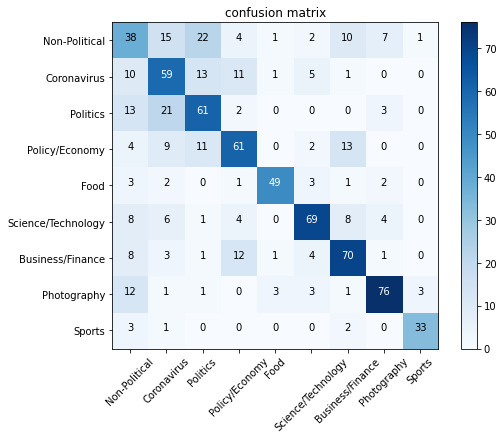

In [116]:
plot_cm(preds, target, category.keys())
# numbers in each row sum up to the number of posts of a certain category(labels on y axis)
# number in each column for a particular row represents the number of posts predicted for a certain category(labels on x axis)

From above matrix,
1. posts having flair ```sports``` are very well predicted by our model. Out of 36 posts in sports category 33 are correctly predicted. This is because posts in this category have certain keywords related to sports, and thats why some(3) posts are mispredicted as ```non-political```
2. Similary flair ```Photography``` is also correctly predicted, Although ```photography``` is misinterpreted as ```non-political``` for almost 12/72 times.
3. ```Food``` is also correctly predicted most of the times, 49/61
4. Flairs ```Coronavirus```, ```Non-Political``` and ```Politics``` are most mispredicted flairs. Even after the number of posts in the test and data is highest for all of them, the number of mispredictions are also highest.
This can be credited to the current pandemic situation where many posts whether it is of non-political category or politics category, they have some words describing the effects and situations of coronavirus pandemic
5. ```politics``` and ```policy/Economic``` are also sharing some features.


### Testing Code for Inference in app

In [0]:
import requests
import numpy as np
import re
import emoji
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#url+='.json'
#response = requests.get(url, headers = {'User-Agent':'Mozilla/5.0'})
#json_file = response.json()
#print(json_file['author_fullname'])

def scrape(url):
    """
    Function to scrape data from url of a reddit post
    Args:
        url (str): url to reddit post
    Return:
        dictionary object containing title, author, post's selftext, top 10 comments.
    """
    # json data at the url
    url+='.json'
    response = requests.get(url, headers = {'User-Agent':'Mozilla/5.0'})
    json_file = response.json()

    # post title, author, textbody
    postContent = json_file[0]['data']['children'][0]['data']
    try:
        headline = postContent['title']
    except:
        headline = ""
    
    try:
        author = postContent['author']
    except:
        author = ""

    try:
        postBody = postContent['selftext']
    except:
        postBody = ""

    # comments on the post
    comments = json_file[1]['data']['children']
    # pick top 10 comments or less if not available
    try:
        comnts = " ".join(comments[i]['data']['body'] for i in range(min(10, len(comments))))
    except:
        comnts = "" 

    return {'headline':headline,
            'author':author,
            'postBody':postBody,
            'comments':comnts}



def textPreProcess(text, rem_stop=True):
    """
    Function to process text data and remove non neccessary information
    1. converting emojis to text
    2. lower casing
    3. removing punctuations, urls
    4. removing stop words
    5. lemmatization 
    Args:
        text (str): text data
        rem_stop (bool): whether to remove stopping words or not
    Return:
        text (str): processed text data
    """
    # converting emojis to text
    text = emoji.demojize(text)
    # removing empty space at start and end of text and lower casing
    text = text.strip().lower()
    # removing punctuation
    PUNCTUATIONS = r'[!()\-[\]{};:"\,<>/?@#$%^&.*_~]'
    text = re.sub(PUNCTUATIONS, "", text)
    # removing url links
    urlPattern = re.compile(r'https?://\S+|www\.\S+')
    urlPattern.sub('', text)

    # updating stopping words list
    if rem_stop:
        stopWords = list(stopwords.words('english'))
    else:
        stopWords = []

    # lemmatizing, removing stop word, removing emojis
    lemmaWords=[]
    Lemma=WordNetLemmatizer()
    for word in text.split():
        # removing stop words
        if word not in stopWords:
            lemmaWords.append(Lemma.lemmatize(word.strip()))
    text = " ".join(lemmaWords)

    return text



def preProcess(scraped_data):
    """
    Function to preprocess scraped data for inference
    Args:
        scraped_data (dict): scraped data containing 
                            author, headline, postbody, comments
    Return:
        author (str): author of the post
        text (str) : preprocessed text data
    """
    scraped = scraped_data
    # appending all the text features except author name
    text = " ".join([scraped['headline'], scraped['postBody'], scraped['comments']])
    author = scraped['author']
    # preprocess text data for inference
    text = textPreProcess(text)

    return text, author

#if '__name__' == '__main__':
#    url = 'https://www.reddit.com/r/india/comments/g1zi21/coronavirus_covid19_megathread_news_and_updates_4/'
#    preProcess(url)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import torch
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig

def loadModel(filepath):
    """
    -Function to load saved model and saved states
    -Args:
        filpath (str): path to the saved model
    """
    # load saved model dictionary
    saved = torch.load(filepath, map_location = 'cpu')
    state_dict = saved['state_dict']
    cat_dict = saved['category']
    return cat_dict, state_dict

class First:
    def __init__(self, path, max_len=200):
        # load model
        self.cat_dict, self.state_dict = loadModel(path)
        self.maxlen = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def getTokens(self, text):
        tokens_dict = self.tokenizer.encode_plus(text = text,
                            add_special_tokens=True,
                            max_length = self.maxlen,
                            pad_to_max_length=True,
                            return_attention_mask=True)

        token_id = torch.tensor(tokens_dict['input_ids'])
        attn_mask = torch.tensor(tokens_dict['attention_mask'])

        return token_id, attn_mask

def predict(text, preload):
    """
    Functiion to predict category(Flair) of the post.
    Args:
        text (str): text extracted from reddit post
        path (str): path to pretrained model
    Returns:
        prediction (str): predicted Flair of the post

    Note: currently the model is trained on only 9 Flair categories
        
    """
    # get tokens and attention mask for text
    tokens, attn_mask = preload.getTokens(text)
    # initializing model
    config = DistilBertConfig(num_labels = 9)
    model = DistilBertForSequenceClassification(config)
    # loading saved parameters
    model.load_state_dict(preload.model)
    model.eval()

    # feed the tokens and attn_mask into the model
    output = model(tokens.unsqueeze(0),
                        attention_mask = attn_mask.unsqueeze(0))
    prediction = output[0].argmax()
    flair = [key for key in preload.cat_dict if preload.cat_dict[key]==prediction]
    return flair[0]



In [0]:
config = DistilBertConfig(num_labels = 9)
model = DistilBertForSequenceClassification(config)

In [0]:
model_path = '/content/drive/My Drive/docs/distilbert_model.pth'
preload = First(model_path)

In [0]:
url = 'https://www.reddit.com/r/india/comments/g64ani/an_aerial_view_of_gangaikonda_cholapuram_temple/'
scraped = scrape(url)
title = scraped['headline']
text, author = preProcess(scraped)
results = [author, title]
flair = predict(text, preload)

tensor([  101,  9682,  3193, 28646, 12676,  8943, 16480,  2721, 17809,  3379,
         9026,  3367,  3379,  6008, 10703,  5121,  3376, 17850,  5243,  2102,
         2915,  3819, 11418,  2063,  2154,  2145,  3342,  2171, 28646, 12676,
         8943,  9905,  2721, 17809,  2109,  3007, 16480,  2721,  2983, 11479,
         3929,  3191,  2465,  1021,  3227,  2919,  3638,  2028,  5881,  2132,
         3120, 11039, 25856,  3367,  9148, 12079,  9006, 16874, 14031,  9028,
         9488, 12096, 15590, 12521, 25746,  2683,  2683, 23499, 23352,  2620,
        22025,  2620,  2620,  2581,  2683, 22025,  6405,  3379, 28646, 12676,
         8943, 16480,  2721, 17809,  2949,  9800,  2629,  4748,  2088,  4348,
         2609, 16770,  2368,  9148,  3211,  5669,  2401, 21759,  9148,  3211,
        24930,  4886, 19648,  2850,  9905,  2721, 17809,  3376,  3376, 22337,
         3379, 28445,  3267,  1005,  1055,  2486,  3233, 18067,  3531,  2425,
        10806,  3252,  3953,  2157,  2187,  2417,  4418,  3728, 